In [1]:
from kbmodpy import kbmod as kb
from trajectoryFiltering import *
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = '../../HITS/test_35/4,6tempExp/new_header/'

In [3]:
files = os.listdir(path)

In [4]:
files.sort()
files = [path+f for f in files]
files = files[:4]
files

['../../HITS/test_35/4,6tempExp/new_header/v410913-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v410969-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411019-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411053-fg.fits']

In [5]:
images = [kb.layered_image(f) for f in files]

Object Generation Parameters

In [6]:
p = kb.psf(1.5)
object_count = 24
x_range = (5,3650)
y_range = (5, 3650)
angle_range = (0.1, 0.5)
velocity_range = (1900, 2900)
flux_range = (800, 4000)

Search Parameters

In [7]:
min_observations = 3
angle_steps = 200
velocity_steps = 180
search_margin = 1.2

In [8]:
print(angle_range[1]-angle_range[0])
print(velocity_range[1]-velocity_range[0])

0.4
1000


Generate Random trajectories within bounds

In [9]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    ang = rd.uniform(*angle_range)
    vel = rd.uniform(*velocity_range)
    traj.x_v = vel*math.cos(ang)
    traj.y_v = vel*math.sin(ang)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

Add a real object to the list of trajectories

In [10]:
if path == '../../HITS/test_35/4,6tempExp/new_header/':
    real_result = kb.trajectory()
    real_result.flux = 5300
    real_result.x = 3123
    real_result.y = 3043
    real_result.x_v = 2425
    real_result.y_v = 1050
    results_key.append(real_result)
results_key[0]

lh: 0.000000 flux: 1626.754639 x: 2896 y: 2300 x_v: 2350.968506 y_v: 572.669556 obs_count: 0

Test that clustering is not able to collapse together too many unique trajectories

In [11]:
len(cluster_trajectories(results_key, dbscan_args=dict(eps=0.007, min_samples=1))[1])

25

Use the generated trajectories to add objects into the images

In [12]:
for t in results_key:
    add_trajectory(images, t, p)

Sanity check

In [13]:
len(match_trajectories(results_key, results_key, 0.01, 1)[0])

25

In [14]:
stack = kb.image_stack(images)

Mask out stars and bad pixels

In [15]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [16]:
stack.apply_mask_flags(flags, flag_exceptions)

In [17]:
stack.apply_master_mask(master_flags, 2)

In [18]:
images = [i.science() for i in stack.get_images()]

Calculate masked percentage of an image to estimate probablilty of placing an object under a mask

In [19]:
img = images[1]
percent_masked = img[np.where(img==-9999.99)].size/img.size
percent_masked

0.15934744897959183

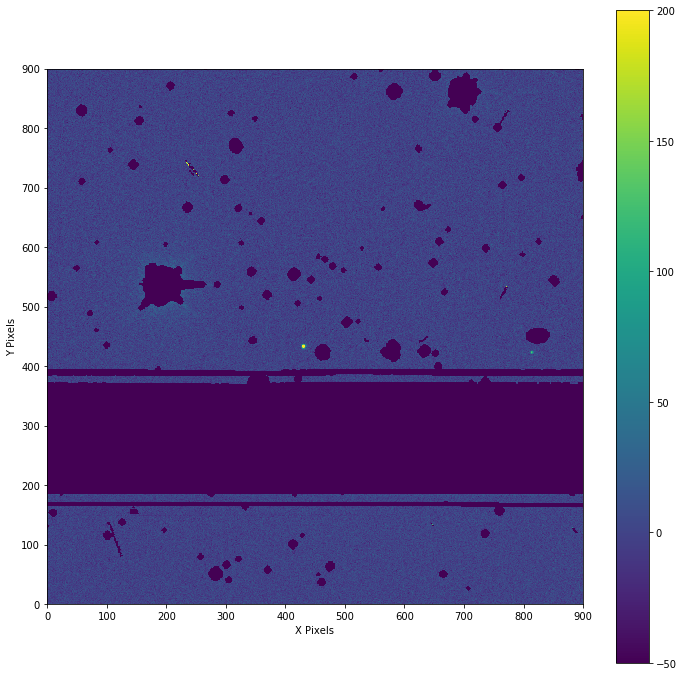

In [20]:
fig = plt.figure(figsize=(12,12))
plt.imshow(images[1] [2700:3600,2900:3800], origin='lower',  vmin=-50, vmax=200)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [21]:
search = kb.stack_search(stack, p)
search.set_debug(True)

In [22]:
search_ang_r = (angle_range[0]/search_margin,
                angle_range[1]*search_margin)
search_vel_r = (velocity_range[0]/search_margin,
                velocity_range[1]*search_margin)
search.gpu(angle_steps,velocity_steps, *angle_range, *velocity_range, min_observations)

In [23]:
search.get_results(0,20)

[lh: 268.536530 flux: 9697.816406 x: 3123 y: 3042 x_v: 2427.378174 y_v: 1049.247559 obs_count: 3,
 lh: 265.922638 flux: 9375.439453 x: 3123 y: 3043 x_v: 2424.368164 y_v: 1042.196655 obs_count: 3,
 lh: 265.922638 flux: 9375.439453 x: 3122 y: 3043 x_v: 2429.471924 y_v: 1044.390747 obs_count: 3,
 lh: 265.236328 flux: 9452.645508 x: 3124 y: 3042 x_v: 2420.179932 y_v: 1051.885742 obs_count: 3,
 lh: 264.632080 flux: 10012.237305 x: 3123 y: 3043 x_v: 2429.471924 y_v: 1044.390747 obs_count: 3,
 lh: 264.632080 flux: 10012.237305 x: 3124 y: 3043 x_v: 2424.368164 y_v: 1042.196655 obs_count: 3,
 lh: 264.317200 flux: 9500.118164 x: 3124 y: 3044 x_v: 2419.264160 y_v: 1040.002563 obs_count: 3,
 lh: 264.317200 flux: 9500.118164 x: 3123 y: 3044 x_v: 2426.447754 y_v: 1037.345825 obs_count: 3,
 lh: 262.812469 flux: 9149.522461 x: 3122 y: 3042 x_v: 2432.478027 y_v: 1051.451904 obs_count: 3,
 lh: 262.812469 flux: 9149.522461 x: 3123 y: 3041 x_v: 2423.161865 y_v: 1058.948608 obs_count: 3,
 lh: 262.467834 fl

In [30]:
#search.region_search(2400, 1040, 50, 255, 3)
search.region_search(0, 0, 3500, 100, 3)

[ix: 3124.000000 iy: 3043.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 262.363678 flux 9595.437500,
 ix: 3123.000000 iy: 3043.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 260.788849 flux 9332.271484,
 ix: 3124.000000 iy: 3042.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 258.531738 flux 9402.122070,
 ix: 3124.000000 iy: 3044.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 258.208099 flux 9374.043945,
 ix: 3123.000000 iy: 3042.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 257.590973 flux 9184.513672,
 ix: 3122.000000 iy: 3043.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 256.821625 flux 8973.864258,
 ix: 3123.000000 iy: 3044.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 256.191071 flux 9090.317383,
 ix: 3125.000000 iy: 3043.000000 fx: 3611.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 255.711121 flux 8986.624023,
 ix: 3122.000000 iy: 3042.000000 fx: 361